In my day-to-day work, I specialize in creating tools for scientific computing, most of which are executed within Jupyter notebooks. One common challenge for new users is grappling with the intricacies of autocompletion, particularly understanding what is essential for effective use. This issue becomes apparent when utilizing autocompletion in scenarios like the following Python code:

```python
# mymodule.py

import numpy as np

_private = "baz"

def f(arr):
    return np.asarray(arr) + 1
```

Upon using Jupyter's autocompletion, the result includes not only `f(arr)` but also `np` (and the path of the module), which is merely a necessary import but not part of my intended "API." 

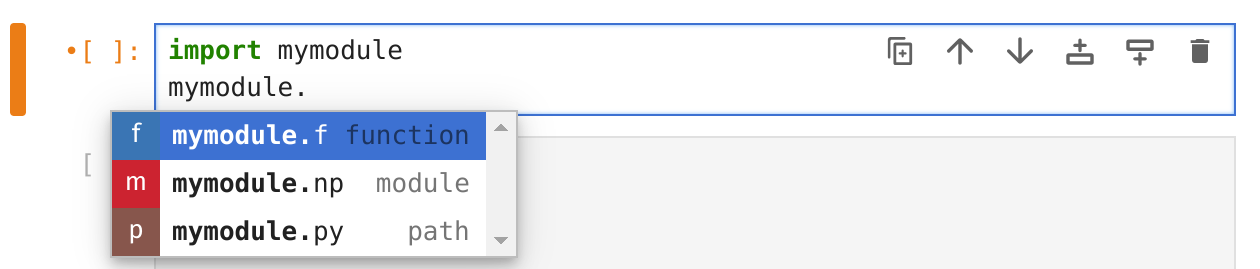

These are what I refer to as 'public but private imports,' and they can be bothersome. Concrete examples of this phenomenon can be observed in modules like `sklearn.pipeline` or `inspect`.

One workaround is to assign private aliases to each import, like so:

```python
# mymodule.py

import numpy as _np

_private = "baz"

def f(arr):
    return _np.asarray(arr) + 1
```

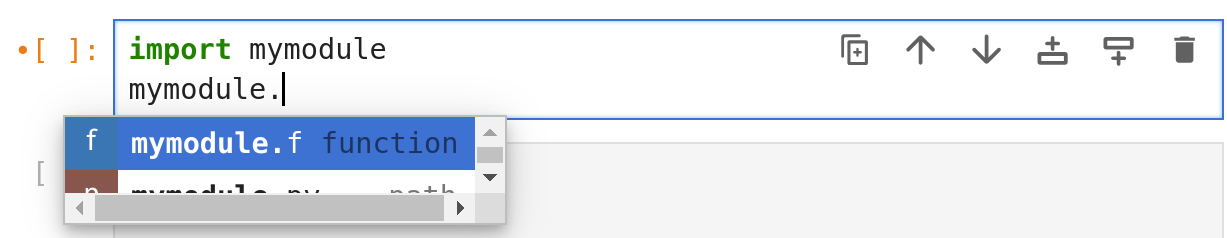

However, with each change of this nature, one must manually search for all instances within functions like `f()` where these private aliases are used.

Other alternatives include having a private module `_module` and a public one `module` (similar to what `pandas.testing` does) or organizing everything within a package and having `__init__.py` expose only what is necessary, as demonstrated by `sklearn.ensemble`.

The last alternative involves redefining the `__dir__` function of the module. This function determines the list of attributes visible during autocompletion on most platforms. Here's an example:

```python
# mymodule.py
import numpy as np

_private = "baz"

def f(arr):
    return np.asarray(arr) + 1

_hidden = ["np"]  # the hidden globals

# dir redefinition that ignores the hidden globals
def __dir__():
    return [attr for attr in globals() if attr not in _hidden]
```

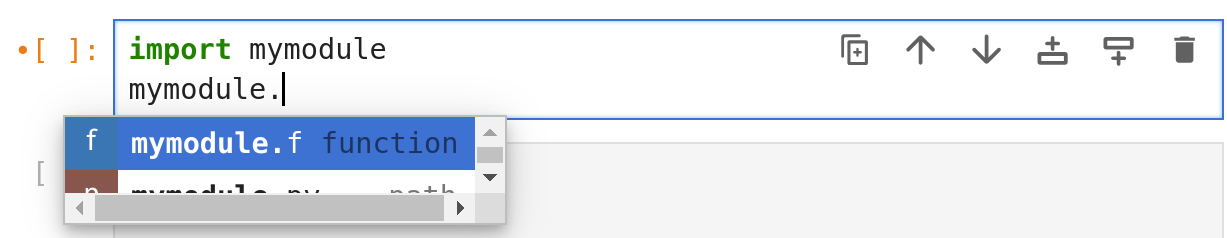

This last option has the advantage of not requiring alterations to the source code where hidden attributes are used. However, developers can still access these attributes if they attempt to do so.

### As a context manager

The only drawback to the previous implementation is the need to explicitly mark the hidden attribute and redefine `__dir__` in each module. However, leveraging Python's `inspect` module, which provides utilities for manipulating execution frames, we can create functionality like the following:

```python
# mymodule.py

from hide import hidden

with hidden():
    import numpy as np

_private = "baz"

def f(arr):
    return np.asarray(arr) + 1
```

By employing such a mechanism, we can enhance the readability and usability of our scientific computing tools within Jupyter environments. This approach minimizes the exposure of unnecessary elements during autocompletion, promoting a cleaner and more focused interface for users.


### The implementation of the `hidden` context manager

The implementation of the context manager can be found in the module [`skcriteria.utils.cmanagers.hidden()`](https://github.com/quatrope/scikit-criteria/blob/fd28bc959b14661cb538150040c082f4715ea528/skcriteria/utils/cmanagers.py#L93)

This Python code defines a context manager called hidden that is designed to hide objects in the global scope within a specified context. The context manager is accompanied by custom exceptions, HiddenAlreadyUsedInThisContext and NonGlobalHidden, to handle specific error scenarios.

When the hidden context manager is used, it captures the current state of the global scope and hides specified objects introduced within the context. The primary purpose is to be used globally, outside of any functions or methods, and it raises an exception (NonGlobalHidden) if used within a local context. Additionally, it ensures that the hidden context manager is not used more than once within the same context by raising another exception (HiddenAlreadyUsedInThisContext).

The implementation details involve retrieving the current frame, checking if it is used globally, capturing the state of the global scope, and customizing the __dir__ attribute to include logic for hiding objects. The __dir__ attribute is replaced with a custom implementation (_DirWithHidden) that hides specified objects from the global scope.

The context manager provides parameters to control the hiding behavior, such as hide_this to determine whether to hide the hidden context manager itself and/or the hidden module, and dry to test the functionality without actually hiding the objects. The code includes informative comments and docstrings to explain its functionality and proper usage.
